In [153]:
import pandas as pd
import statistics
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import statistics as stat
from scipy.stats import binom
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Rectangle
# splitting merge_data into train test and split
from sklearn.model_selection import train_test_split, cross_validate
from scipy import stats
from scipy.stats import normaltest
import os 
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
import matplotlib as mpl
import warnings; warnings.filterwarnings(action='once')
# to keep track of training time
import datetime
# logistic regression model
from sklearn.linear_model import LogisticRegression
# metrics used for evaluation
from sklearn.metrics import f1_score, matthews_corrcoef
# visualizations
from yellowbrick.classifier import ClassPredictionError, ConfusionMatrix
from sklearn.metrics import plot_roc_curve
# KNN imputation
from sklearn.impute import KNNImputer
# normalizer
from sklearn.preprocessing import Normalizer
# variance threshold
from sklearn.feature_selection import VarianceThreshold
# RFECV
from sklearn.model_selection import StratifiedKFold
# random forest
# evaluation metric
from sklearn.metrics import matthews_corrcoef, make_scorer
from scipy import stats 
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split 
from sklearn.model_selection import cross_val_score # Evaluate a score by cross-validation
from sklearn.model_selection import GridSearchCV # Exhaustive search over specified parameter values for an estimator
from sklearn.metrics import classification_report # Build a text report showing the main classification metrics
from sklearn.metrics import accuracy_score # Accuracy classification score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # to show confusion matrix
from sklearn import metrics # Evaluate ROC curve
from sklearn.experimental import enable_iterative_imputer # Enables IterativeImputer. The API and results of this estimator might change without any deprecation cycle
from sklearn.impute import IterativeImputer
from imblearn.combine import SMOTEENN # Combine over- and under-sampling using SMOTE and Edited Nearest Neighbours
from sklearn import decomposition
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.metrics import plot_confusion_matrix
from matplotlib.colors import ListedColormap
from boruta import BorutaPy
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from BorutaShap import BorutaShap
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

# score libraries 
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import cohen_kappa_score

Read files 

In [2]:
def read_secom():
    path ='../secom.data'
    df = pd.read_csv(path, delimiter=' ', header=None, na_values=['NaN'])
    df.columns = ['feature'+str(x+1) for x in range(len(df.columns))]
    return df

#%%
def read_labels():
    path = '../secom_labels.data'
    df = pd.read_csv(path, delimiter=' ', header=None, na_values=['NaN'])
    df.columns = ['status','timestamp']
    df['timestamp'] = pd.to_datetime(df['timestamp'],dayfirst=True)
    return df

#read 2 df 
df_features = read_secom()
df_target = read_labels()

## Function for remove dup and mutilcolinea

In [73]:
def remove_duplicated_columns(df):
    dict_duplicate_pair = {}
    dict_duplicate_matches = {}
    list_duplicate = []
    to_remove = []
    for i in range(0, len(df.columns)):
        l = []
        for j in range(i+1,len(df.columns)):
            dict_duplicate_pair[str(i+1)+';'+str(j+1)] = df.iloc[:,i].equals(df.iloc[:,j])
            if df.iloc[:,i].equals(df.iloc[:,j]) == True:
                if j not in list_duplicate:
                    l.append(j)
                    to_remove.append('feature_'+str(j+1))
                list_duplicate.append(i)
                list_duplicate.append(j)
        if len(l)!=0:
            dict_duplicate_matches[i] = l


    df_duplicate_pair = pd.DataFrame.from_dict(dict_duplicate_pair, orient='index')
    df_duplicate_pair.columns=['duplicate']

    df_duplicate_matches = pd.DataFrame.from_dict(dict_duplicate_matches, orient='index')

    
    df = df.drop(columns=to_remove, axis = 1)

    return df

# X = remove_duplicated_columns(X)
# X.shape

#mutlicollinearity
#Remove the highly collinear features from data
def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model 
        to generalize and improves the interpretability of the model.

    Inputs: 
        x: features dataframe
        threshold: features with correlations greater than this value are removed

    Output: 
        dataframe that contains only the non-highly-collinear features
    '''

    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                #Print the correlated features and the correlation value
                #print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns=drops)

    return x



# Data Preparation

## Merge data

In [3]:
df= pd.concat([df_features,df_target],axis=1)

## Split Training and test data 

In [4]:
x = df.iloc[:,:590]
y = df.iloc[:,590]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1,stratify=y)

In [5]:
x_train.isna().sum().sum()

33219

## reducing dimensionality 

### remove missing values 

In [5]:
def null_values(df):
    """a function to show null values with percentage"""
    nv=pd.concat([df.isnull().sum(), 100 * df.isnull().sum()/df.shape[0]],axis=1).rename(columns={0:'Missing_Records', 1:'Percentage (%)'})
    return nv[nv.Missing_Records>0].sort_values('Missing_Records', ascending=False)

In [6]:
x_train_na = null_values(x_train)
x_train_na

,Missing_Records,Percentage (%)
feature293,1144,91.300878
feature158,1144,91.300878
feature159,1144,91.300878
feature294,1144,91.300878
feature221,1072,85.554669
...,...,...
feature500,1,0.079808
feature367,1,0.079808
feature377,1,0.079808
feature378,1,0.079808


In [7]:
miss_threshold=80
x_train_na= x_train_na[x_train_na["Percentage (%)"] > miss_threshold]
x_train_na

,Missing_Records,Percentage (%)
feature293,1144,91.300878
feature158,1144,91.300878
feature159,1144,91.300878
feature294,1144,91.300878
feature221,1072,85.554669
feature86,1072,85.554669
feature359,1072,85.554669
feature493,1072,85.554669


In [8]:
x_train_new = x_train.drop(axis=1, columns=x_train_na.index)
x_train_new.shape

(1253, 582)

### removing constant voltality

In [9]:
x_train_new_eda= x_train_new.describe().T
x_train_new_eda

,count,mean,std,min,25%,50%,75%,max
feature1,1248.0,3014.113686,73.877303,2743.2400,2966.2300,3011.40500,3056.310000,3356.3500
feature2,1247.0,2496.400585,79.188651,2162.8700,2452.3350,2500.38000,2539.600000,2846.4400
feature3,1243.0,2200.216525,29.939025,2060.6600,2180.8611,2200.98890,2218.055500,2315.2667
feature4,1243.0,1394.907987,436.632421,0.0000,1083.8858,1283.43680,1593.122000,3715.0417
feature5,1243.0,4.018582,54.572445,0.6815,1.0160,1.31710,1.525700,1114.5366
...,...,...,...,...,...,...,...,...
feature586,1252.0,3.084501,3.968128,1.1975,2.3058,2.74655,3.258475,99.3032
feature587,1252.0,0.021521,0.012421,-0.0060,0.0134,0.02070,0.027600,0.1028
feature588,1252.0,0.016344,0.008698,0.0042,0.0106,0.01480,0.019800,0.0799
feature589,1252.0,0.005248,0.002850,0.0012,0.0033,0.00460,0.006300,0.0286


In [10]:
x_train_new_eda[x_train_new_eda['std']==0]
x_train_new_std= x_train_new_eda[x_train_new_eda["std"] == 0]
x_train_new_std

,count,mean,std,min,25%,50%,75%,max
feature6,1243.0,100.0,0.0,100.0,100.0,100.0,100.0,100.0
feature14,1251.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
feature43,1253.0,70.0,0.0,70.0,70.0,70.0,70.0,70.0
feature50,1253.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
feature53,1253.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
feature535,1247.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
feature536,1247.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
feature537,1247.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
feature538,1247.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
x_train_new_2 = x_train_new.drop(axis=1, columns=x_train_new_std.index)
x_train_new_2.shape

(1253, 466)

## Outlier Treatment

In [12]:
x_train_3s=x_train_new_2.copy()

In [13]:
def zscore(df,cols,thr):
    for col in cols:
        mean=df[col].mean()
        std=df[col].std()
        upper_bound=mean+ thr*std
        lower_bound=mean- thr*std
        df[col]=np.where(df[col]>upper_bound,upper_bound,np.where(df[col]<lower_bound,lower_bound,df[col]))

In [14]:
zscore(x_train_3s,x_train_3s.columns,3)

# Checking

In [15]:
x_train_new_2['feature4'].mean()

1394.907986725665

In [17]:

x_train_new_2['feature4'].std()

436.63242083048897

In [18]:
x_train_new_2['feature4'].mean()+3*x_train_new_2['feature4'].std()

2704.805249217132

In [19]:
x_train_new_2['feature4'].max()

3715.0417

In [20]:
x_train_3s['feature4'].max()


2704.805249217132

## Imputation

### KNN Imputation

In [16]:
#scaling before distanced based algo
scaler = MinMaxScaler()
x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train_3s), columns=x_train_3s.columns)
x_train_scaled

,feature1,feature2,feature3,feature4,feature5,feature7,feature8,feature9,feature10,feature11,...,feature581,feature582,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590
0,0.648120,0.201366,0.538010,0.452172,0.006439,0.392017,0.787343,0.527160,0.680406,0.663699,...,0.345437,0.190010,0.514663,0.075172,0.110693,0.071958,0.527907,0.397495,0.373085,0.182951
1,0.471228,0.489118,0.250017,0.318042,0.003555,0.606695,0.806973,0.430272,0.451391,0.514345,...,NaN,NaN,0.224461,0.208979,0.166039,0.205512,0.353482,0.611932,0.547721,0.436456
2,0.564671,0.250573,0.351025,0.514797,0.002089,0.753605,0.865862,0.613416,0.734617,0.735677,...,NaN,NaN,0.319527,0.081186,0.110693,0.079049,0.413682,0.640698,0.627101,0.368023
3,0.510211,0.300896,0.632400,0.543962,0.005265,0.467181,0.715366,0.483910,0.387223,0.678095,...,0.191093,0.137507,0.744823,0.061641,0.089938,0.057659,0.530994,0.258894,0.206388,0.132398
4,0.513934,0.368646,0.597947,0.633548,0.001678,0.476510,0.777528,0.610033,0.401606,0.399181,...,NaN,NaN,0.559694,0.130800,0.124529,0.125897,0.347307,0.188287,0.246077,0.183597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1248,0.597451,0.468702,0.581926,0.602601,0.002028,0.483641,0.872406,0.581040,0.146039,0.582724,...,NaN,NaN,0.694788,0.172896,0.145284,0.165038,0.498579,0.196132,0.166698,0.118079
1249,0.490065,0.645495,0.636173,0.467074,0.004245,0.502029,0.744811,0.486810,0.421520,0.359593,...,NaN,NaN,0.404586,0.027062,0.041510,0.027184,0.517102,0.452412,0.508031,0.207902
1250,0.545630,0.784278,0.382138,0.741741,0.005230,0.349415,0.829874,0.448393,0.563133,0.661900,...,NaN,NaN,0.349548,0.102234,0.117611,0.100454,0.552604,0.193517,0.214325,0.103733
1251,0.525033,0.514521,0.385973,1.000000,0.004806,0.000000,0.875677,0.304874,0.431477,0.436969,...,0.029399,0.127442,0.604725,0.147337,0.172957,0.141052,0.277846,0.033996,0.031752,0.122707


In [17]:
# impute missing values and save it as a temporary dataset.
# as per Aras research you need to separately scale before knn imputataion
#use fit_transform on training data and only transform on test data
knn = KNNImputer()
#knn.fit(x_train_scaled)
#imputed_train = pd.DataFrame(knn.fit_transform(x_train_3s), columns = x_train_3s.columns)
imputed_train = pd.DataFrame(knn.fit_transform(x_train_scaled), columns = x_train_scaled.columns)

In [21]:
retransformed_train= pd.DataFrame(scaler.inverse_transform(imputed_train), columns=imputed_train.columns)

# Checking

In [23]:
imputed_train.isna().sum().sum()

0

In [24]:
imputed_train

,feature1,feature2,feature3,feature4,feature5,feature7,feature8,feature9,feature10,feature11,...,feature581,feature582,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590
0,0.648120,0.201366,0.538010,0.452172,0.006439,0.392017,0.787343,0.527160,0.680406,0.663699,...,0.345437,0.190010,0.514663,0.075172,0.110693,0.071958,0.527907,0.397495,0.373085,0.182951
1,0.471228,0.489118,0.250017,0.318042,0.003555,0.606695,0.806973,0.430272,0.451391,0.514345,...,0.423344,0.230365,0.224461,0.208979,0.166039,0.205512,0.353482,0.611932,0.547721,0.436456
2,0.564671,0.250573,0.351025,0.514797,0.002089,0.753605,0.865862,0.613416,0.734617,0.735677,...,0.277819,0.172041,0.319527,0.081186,0.110693,0.079049,0.413682,0.640698,0.627101,0.368023
3,0.510211,0.300896,0.632400,0.543962,0.005265,0.467181,0.715366,0.483910,0.387223,0.678095,...,0.191093,0.137507,0.744823,0.061641,0.089938,0.057659,0.530994,0.258894,0.206388,0.132398
4,0.513934,0.368646,0.597947,0.633548,0.001678,0.476510,0.777528,0.610033,0.401606,0.399181,...,0.236661,0.336388,0.559694,0.130800,0.124529,0.125897,0.347307,0.188287,0.246077,0.183597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1248,0.597451,0.468702,0.581926,0.602601,0.002028,0.483641,0.872406,0.581040,0.146039,0.582724,...,0.217552,0.130255,0.694788,0.172896,0.145284,0.165038,0.498579,0.196132,0.166698,0.118079
1249,0.490065,0.645495,0.636173,0.467074,0.004245,0.502029,0.744811,0.486810,0.421520,0.359593,...,0.249890,0.155535,0.404586,0.027062,0.041510,0.027184,0.517102,0.452412,0.508031,0.207902
1250,0.545630,0.784278,0.382138,0.741741,0.005230,0.349415,0.829874,0.448393,0.563133,0.661900,...,0.318978,0.106352,0.349548,0.102234,0.117611,0.100454,0.552604,0.193517,0.214325,0.103733
1251,0.525033,0.514521,0.385973,1.000000,0.004806,0.000000,0.875677,0.304874,0.431477,0.436969,...,0.029399,0.127442,0.604725,0.147337,0.172957,0.141052,0.277846,0.033996,0.031752,0.122707


In [26]:
retransformed_train

,feature1,feature2,feature3,feature4,feature5,feature7,feature8,feature9,feature10,feature11,...,feature581,feature582,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590
0,3079.77,2354.51,2207.0444,1269.607800,1.7571,97.018900,0.1221,1.4607,0.0155,0.0093,...,0.00590,68.74440,0.5001,0.0110,0.0034,2.1899,0.0282,0.0194,0.0059,68.7444
1,3001.36,2491.23,2155.3111,918.216100,1.2753,105.047800,0.1227,1.4206,-0.0052,0.0010,...,0.00696,83.34452,0.4943,0.0199,0.0042,4.0318,0.0169,0.0276,0.0081,163.9998
2,3042.78,2377.89,2173.4556,1433.673200,1.0304,110.542200,0.1245,1.4964,0.0204,0.0133,...,0.00498,62.24328,0.4962,0.0114,0.0034,2.2877,0.0208,0.0287,0.0091,138.2861
3,3018.64,2401.80,2224.0000,1510.079700,1.5611,99.830000,0.1199,1.4428,-0.0110,0.0101,...,0.00380,49.74900,0.5047,0.0101,0.0031,1.9927,0.0284,0.0141,0.0038,49.7490
4,3020.29,2433.99,2217.8111,1744.777100,0.9618,100.178900,0.1218,1.4950,-0.0097,-0.0054,...,0.00442,121.70308,0.5010,0.0147,0.0036,2.9338,0.0165,0.0114,0.0043,68.9871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1248,3057.31,2481.53,2214.9333,1663.702400,1.0203,100.445600,0.1247,1.4830,-0.0328,0.0048,...,0.00416,47.12526,0.5037,0.0175,0.0039,3.4736,0.0263,0.0117,0.0033,44.3686
1249,3009.71,2565.53,2224.6778,1308.647900,1.3907,101.133300,0.1208,1.4440,-0.0079,-0.0076,...,0.00460,56.27146,0.4979,0.0078,0.0024,1.5724,0.0275,0.0215,0.0076,78.1199
1250,3034.34,2631.47,2179.0445,2028.220800,1.5552,95.425600,0.1234,1.4281,0.0049,0.0092,...,0.00554,38.47760,0.4968,0.0128,0.0035,2.5829,0.0298,0.0116,0.0039,38.9781
1251,3025.21,2503.30,2179.7333,2704.805249,1.4843,82.357569,0.1248,1.3687,-0.0070,-0.0033,...,0.00160,46.10760,0.5019,0.0158,0.0043,3.1428,0.0120,0.0055,0.0016,46.1076


## Feature Selection

### Boruta Shap FS Function

In [169]:
def BorutaShap_FS (X, y,method_option) :
    #modelshap = RandomForestClassifier(n_jobs=-1,n_estimators=100, class_weight='balanced_subsample', max_depth=5, random_state=100)
    modelshap = RandomForestClassifier(n_jobs=-1,n_estimators=100, max_depth=5, random_state=100)

    # define model for resp. classifier
    modelshap.fit(X,y)
    feature_names = np.array(X.columns)
    # define Boruta Sahp feature selection method
    feature_selector = BorutaShap(model=modelshap,
                              importance_measure=method_option,
                              classification=True)  # find all relevant features
    feature_selector.fit(X,y,n_trials=100,sample = False, verbose = True,random_state=100)  
    #feature_selector.plot(which_features='accepted',figsize=(20,10))
    tentative=X.loc[:,feature_selector.tentative]
    selected=feature_selector.Subset()
    selten=pd.concat([selected,tentative],axis=1)
    # call transform() on X to filter it down to selected features
    return  selten

In [170]:
list_method_t=['shap','gini']
list_borshap_t = []
#order=0

for m in list_method_t:
    Output_t = BorutaShap_FS(retransformed_train,y_train,m)
    list_borshap_t.append(Output_t)
    
for r in range(len(list_borshap_t)):
    print(list_borshap_t[r])

  0%|          | 0/100 [00:00<?, ?it/s]`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  1%|          | 1/100 [00:00<01:07,  1.47it/s]`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  2%|▏         | 2/100 [00:01<01:05,  1.50it/s]`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specif

18 attributes confirmed important: ['feature299', 'feature332', 'feature133', 'feature442', 'feature283', 'feature349', 'feature34', 'feature124', 'feature164', 'feature60', 'feature66', 'feature342', 'feature435', 'feature22', 'feature461', 'feature206', 'feature478', 'feature65']
447 attributes confirmed unimportant: ['feature419', 'feature196', 'feature378', 'feature345', 'feature45', 'feature388', 'feature542', 'feature162', 'feature91', 'feature197', 'feature246', 'feature130', 'feature106', 'feature128', 'feature62', 'feature79', 'feature77', 'feature35', 'feature215', 'feature440', 'feature511', 'feature123', 'feature300', 'feature540', 'feature431', 'feature149', 'feature61', 'feature487', 'feature319', 'feature212', 'feature421', 'feature391', 'feature322', 'feature317', 'feature297', 'feature120', 'feature80', 'feature276', 'feature270', 'feature112', 'feature386', 'feature295', 'feature457', 'feature497', 'feature409', 'feature488', 'feature420', 'feature54', 'feature170', '

100%|██████████| 100/100 [00:39<00:00,  2.56it/s]

11 attributes confirmed important: ['feature299', 'feature442', 'feature349', 'feature3', 'feature60', 'feature66', 'feature65', 'feature427', 'feature461', 'feature154', 'feature133']
455 attributes confirmed unimportant: ['feature419', 'feature196', 'feature378', 'feature345', 'feature45', 'feature388', 'feature542', 'feature162', 'feature91', 'feature197', 'feature246', 'feature435', 'feature130', 'feature106', 'feature128', 'feature62', 'feature79', 'feature77', 'feature35', 'feature215', 'feature440', 'feature511', 'feature123', 'feature300', 'feature540', 'feature431', 'feature149', 'feature61', 'feature487', 'feature319', 'feature212', 'feature421', 'feature391', 'feature322', 'feature317', 'feature297', 'feature120', 'feature80', 'feature276', 'feature270', 'feature112', 'feature386', 'feature295', 'feature457', 'feature497', 'feature409', 'feature488', 'feature420', 'feature54', 'feature170', 'feature429', 'feature430', 'feature470', 'feature96', 'feature354', 'feature526', 'f

### RFE with RF and SVM

In [166]:
def RFE_FS (X, y,classify) :
    scaler = MinMaxScaler()
    X_scaled= pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    feature_names = np.array(X_scaled.columns)
    if classify == 'RF':
    # define random forest classifier
        model = RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample', max_depth=5, random_state=100)
       
    if classify== 'SVM':
        model = SVC(kernel='linear',C=5)
        #rfe = RFECV(estimator = model,scoring='accuracy')
    # find all relevant features
    model.fit(X_scaled, y)
    rfe = RFE(estimator = model,n_features_to_select = 15)
    rfe.fit(X_scaled,y)

    # check selected features
    rfe.support_

    # check ranking of features
    rfe.ranking_

    # zip feature names, ranks, and decisions 
    feature_ranks = list(zip(feature_names, 
                             rfe.ranking_, 
                             rfe.support_))

    final_features_rfe = list()
    indexes = np.where(rfe.ranking_ <= 2)
    for x in np.nditer(indexes):
        final_features_rfe.append(feature_names[x])
    
    
    # unscale the data before return
    X_unscaled=pd.DataFrame(scaler.inverse_transform(X_scaled), columns=X_scaled.columns)
    ff_rfe=pd.DataFrame(X_unscaled.filter(final_features_rfe))
    

 # call transform() on X to filter it down to selected features
    return  ff_rfe

In [32]:
#RFE function with random forest

#def RFE_FS (X, y,classify) :
#    feature_names = np.array(X.columns)
#    if classify == 'RF':
#    # define random forest classifier
#        model = RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample', max_depth=5, random_state=100)
#        #model.fit(X, y)
#        #rfe = RFE(estimator = model,n_features_to_select = 15)
#    if classify== 'SVM':
#        model = SVC(kernel='linear',C=5)
#        #model.fit(X, y)
#        #rfe = RFECV(estimator = model,scoring='accuracy')
#    # find all relevant features
#    model.fit(X, y)
#    rfe = RFE(estimator = model,n_features_to_select = 15)
#    rfe.fit(X,y)
#
#    # check selected features
#    rfe.support_
#
#    # check ranking of features
#    rfe.ranking_
#
#    # zip feature names, ranks, and decisions 
#    feature_ranks = list(zip(feature_names, 
#                             rfe.ranking_, 
#                             rfe.support_))
#
#    # print the results
#    for feat in feature_ranks:
#        print('Feature: {:<30} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))
#        
#    final_features_rfe = list()
#    indexes = np.where(rfe.ranking_ <= 1)
#    for x in np.nditer(indexes):
#        final_features_rfe.append(feature_names[x])
#    print(final_features_rfe)
#    
#    # unscale the data before return
#    ff_rfe_scaled=pd.DataFrame(X.filter(final_features_rfe))
#    ff_rfe_unscaled=pd.DataFrame(scaler.inverse_transform(X), columns=X.columns)
#
# # call transform() on X to filter it down to selected features
#    return  ff_rfe_unscaled, final_features_rfe

In [168]:
list_clf=['RF','SVM']
list_rfe = []
#list_ff_rfe=[]

for c in list_clf:
    #bf_rfe, ff_rfe = RFE_FS(imputed_train,y_train,c)
    bf_rfe = RFE_FS(retransformed_train,y_train,c)
    list_rfe.append(bf_rfe)
    #list_ff_rfe.append (ff_rfe)
    
for l in range(len(list_rfe)):
    print("list of dataframes \n\n",list_rfe[l])
    #print("list of chosen features \n\n", list_ff_rfe[l])

list of dataframes 

       feature1  feature20  feature22  feature34  feature60  feature112  \
0      3079.77    12.3686   -4750.75     8.6915     0.6991   231.77836   
1      3001.36    12.4959   -5410.75     8.3006    -1.4173   231.11734   
2      3042.78    12.5553   -6456.75     8.7418    10.2355   233.86028   
3      3018.64    12.4469   -5775.00     8.6829     9.8518   230.74060   
4      3020.29    12.4618   -6900.50     8.5891     1.0336   232.95828   
...        ...        ...        ...        ...        ...         ...   
1248   3057.31    12.4824   -6451.75     9.1156     3.2964   232.09044   
1249   3009.71    12.5280   -5470.25     8.4278     3.0345   232.78650   
1250   3034.34    12.6278   -5972.75     8.5155    11.4855   231.24302   
1251   3025.21    12.5373   -5735.25     9.0650    -2.3109   233.02690   
1252   2997.07    12.5724   -5527.00     8.6309     0.3764   231.19850   

      feature122  feature130  feature131  feature154  feature206  feature337  \
0        

In [34]:
list_rfe

[      feature1  feature2   feature3     feature4  feature5    feature7  \
 0      3079.77   2354.51  2207.0444  1269.607800    1.7571   97.018900   
 1      3001.36   2491.23  2155.3111   918.216100    1.2753  105.047800   
 2      3042.78   2377.89  2173.4556  1433.673200    1.0304  110.542200   
 3      3018.64   2401.80  2224.0000  1510.079700    1.5611   99.830000   
 4      3020.29   2433.99  2217.8111  1744.777100    0.9618  100.178900   
 ...        ...       ...        ...          ...       ...         ...   
 1248   3057.31   2481.53  2214.9333  1663.702400    1.0203  100.445600   
 1249   3009.71   2565.53  2224.6778  1308.647900    1.3907  101.133300   
 1250   3034.34   2631.47  2179.0445  2028.220800    1.5552   95.425600   
 1251   3025.21   2503.30  2179.7333  2704.805249    1.4843   82.357569   
 1252   2997.07   2543.11  2256.1222  1226.221700    1.4656  106.312200   
 
       feature8  feature9  feature10  feature11  ...  feature581  feature582  \
 0       0.1221   

In [175]:
#heatmap of RFE SVm
list_rfe[1].corr()

,feature54,feature57,feature60,feature61,feature64,feature73,feature111,feature112,feature130,feature250,feature334,feature339,feature425,feature472,feature567,feature569
feature54,1.000000,0.132320,-0.052030,0.308029,0.070501,0.096315,0.038992,-0.055656,0.085646,-0.002857,0.081356,-0.069016,0.005149,-0.100599,-0.005046,0.001444
feature57,0.132320,1.000000,0.128353,-0.701830,-0.073939,-0.413008,0.046746,-0.097644,-0.046297,-0.026901,-0.318450,-0.153918,0.013140,0.120334,-0.047555,-0.035833
feature60,-0.052030,0.128353,1.000000,-0.001464,-0.133462,-0.142635,-0.014551,0.049563,0.238151,0.002920,-0.009123,0.011290,-0.000861,-0.022655,-0.028408,-0.024119
feature61,0.308029,-0.701830,-0.001464,1.000000,0.072241,0.462971,-0.061623,0.114170,0.123151,-0.006199,0.241834,0.030474,-0.021489,-0.297640,0.026874,0.020858
feature64,0.070501,-0.073939,-0.133462,0.072241,1.000000,-0.214581,0.068005,-0.032840,0.068463,0.076817,0.137060,0.131753,0.040623,-0.003839,-0.029282,-0.031898
feature73,0.096315,-0.413008,-0.142635,0.462971,-0.214581,1.000000,-0.051659,0.063022,-0.059138,-0.005298,0.141351,0.072883,-0.030990,-0.077182,0.086307,0.073903
feature111,0.038992,0.046746,-0.014551,-0.061623,0.068005,-0.051659,1.000000,-0.581085,-0.065611,-0.019473,-0.029608,-0.022270,0.008514,0.108215,-0.045657,-0.031723
feature112,-0.055656,-0.097644,0.049563,0.114170,-0.032840,0.063022,-0.581085,1.000000,0.237757,0.041236,0.059831,0.023750,-0.080669,-0.085480,0.014365,0.001382
feature130,0.085646,-0.046297,0.238151,0.123151,0.068463,-0.059138,-0.065611,0.237757,1.000000,-0.004477,0.037386,-0.004829,-0.055897,-0.037091,-0.012967,-0.002641
feature250,-0.002857,-0.026901,0.002920,-0.006199,0.076817,-0.005298,-0.019473,0.041236,-0.004477,1.000000,0.034892,0.035553,0.011918,-0.005223,-0.012149,-0.014186


<AxesSubplot:>

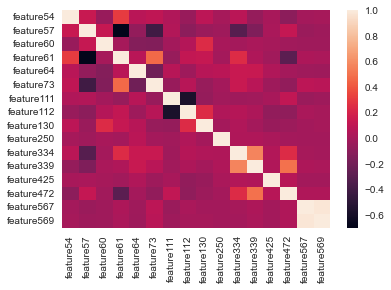

In [176]:
sns.heatmap(list_rfe[1].corr())

##### Checking

In [33]:
list_rfe

[      feature1  feature20  feature22  feature34  feature60  feature112  \
 0     0.648120   0.442228   0.700874   0.193347   0.459091    0.357859   
 1     0.471228   0.556530   0.508093   0.123900   0.422373    0.273036   
 2     0.564671   0.609865   0.202565   0.202283   0.624540    0.625015   
 3     0.510211   0.512533   0.401699   0.191819   0.617883    0.224692   
 4     0.513934   0.525912   0.072950   0.175154   0.464895    0.509269   
 ...        ...        ...        ...        ...        ...         ...   
 1248  0.597451   0.544409   0.204026   0.268692   0.504152    0.397906   
 1249  0.490065   0.585353   0.490714   0.146498   0.499608    0.487226   
 1250  0.545630   0.674962   0.343938   0.162079   0.646226    0.289163   
 1251  0.525033   0.593703   0.413310   0.259703   0.406870    0.518074   
 1252  0.461550   0.625219   0.474138   0.182581   0.453493    0.283450   
 
       feature122  feature131  feature154  feature206  feature337  feature342  \
 0       0.457841

In [34]:
list_ff_rfe

[['feature1',
  'feature20',
  'feature22',
  'feature34',
  'feature60',
  'feature112',
  'feature122',
  'feature131',
  'feature154',
  'feature206',
  'feature337',
  'feature342',
  'feature489',
  'feature519',
  'feature520'],
 ['feature54',
  'feature57',
  'feature60',
  'feature64',
  'feature73',
  'feature111',
  'feature112',
  'feature130',
  'feature250',
  'feature334',
  'feature339',
  'feature425',
  'feature472',
  'feature567',
  'feature569']]

### RFE with SVM rbf 

In [172]:
def RFE_FS_rbf (X, y) :
    scaler = MinMaxScaler()
    X_scaled= pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    feature_names = np.array(X_scaled.columns)
    #if classify == 'RF':
    # define random forest classifier
        #model = RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample', max_depth=5, random_state=100)
       
    #if classify== 'SVM':
    model = SVC(kernel='rbf',C=5)
        #rfe = RFECV(estimator = model,scoring='accuracy')
    # find all relevant features
    model.fit(X_scaled, y)
    rfe = RFE(estimator = model,n_features_to_select = 25)
    rfe.fit(X_scaled,y)

    # check selected features
    rfe.support_

    # check ranking of features
    rfe.ranking_

    # zip feature names, ranks, and decisions 
    feature_ranks = list(zip(feature_names, 
                             rfe.ranking_, 
                             rfe.support_))

    final_features_rfe = list()
    indexes = np.where(rfe.ranking_ <= 1)
    for x in np.nditer(indexes):
        final_features_rfe.append(feature_names[x])
    
    
    # unscale the data before return
    X_unscaled=pd.DataFrame(scaler.inverse_transform(X_scaled), columns=X_scaled.columns)
    ff_rfe=pd.DataFrame(X_unscaled.filter(final_features_rfe))
    

 # call transform() on X to filter it down to selected features
    return  ff_rfe

In [174]:
 rfe_rbf = RFE_FS_rbf(retransformed_train,y_train)

ValueError: when `importance_getter=='auto'`, the underlying estimator SVC should have `coef_` or `feature_importances_` attribute. Either pass a fitted estimator to feature selector or call fit before calling transform.

### BorutaPy with RF 

In [178]:
#Boruta function with random forest

def Boruta_FS (X, y) :
    feature_names = np.array(X.columns)

    # define random forest classifier
    model = RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample', max_depth=5, random_state=100)
    model.fit(X, y)
    # define Boruta feature selection method
    
    feature_selector = BorutaPy(model, n_estimators='auto', verbose=2, random_state=100, max_iter=140)

    # find all relevant features
    feature_selector.fit(X.to_numpy(),y)

    # check selected features
    feature_selector.support_

    # check ranking of features
    feature_ranking=feature_selector.ranking_

    # zip feature names, ranks, and decisions 
    feature_ranks = list(zip(feature_names, 
                             feature_selector.ranking_, 
                             feature_selector.support_))

    # print the results
    for feat in feature_ranks:
        print('Feature: {:<30} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))
        
    final_features = list()
    indexes = np.where(feature_selector.ranking_ <= 2)
    for x in np.nditer(indexes):
        final_features.append(feature_names[x])
    print(final_features)
    
 # call transform() on X to filter it down to selected features
    return pd.DataFrame(X.filter(final_features)) , final_features, feature_ranking

In [179]:
X_train , final_features, feature_ranking = Boruta_FS(retransformed_train,y_train)# 132 iterations result in 14

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Iteration: 	1 / 140
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	2 / 140
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	3 / 140
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	4 / 140
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	5 / 140
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	6 / 140
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	7 / 140
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	8 / 140
Confirmed: 	0
Tentative: 	16
Rejected: 	450
Iteration: 	9 / 140
Confirmed: 	1
Tentative: 	15
Rejected: 	450
Iteration: 	10 / 140
Confirmed: 	1
Tentative: 	15
Rejected: 	450
Iteration: 	11 / 140
Confirmed: 	1
Tentative: 	15
Rejected: 	450
Iteration: 	12 / 140
Confirmed: 	3
Tentative: 	13
Rejected: 	450
Iteration: 	13 / 140
Confirmed: 	3
Tentative: 	13
Rejected: 	450
Iteration: 	14 / 140
Confirmed: 	3
Tentative: 	13
Rejected: 	450
Iteration: 	15 / 140
Confirmed: 	3
Tentative: 	13
Rejected: 	450
Iteration: 	16 / 140
Confirmed: 	4
Tentat

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [180]:
X_train

,feature20,feature22,feature34,feature60,feature104,feature122,feature130,feature131,feature206,feature248,feature342,feature349,feature427,feature478,feature511,feature520
0,12.3686,-4750.75,8.6915,0.6991,-0.0095,15.76,0.0000,0.8203,9.22,0.015200,2.6547,0.02370,1.3155,6.0266,84.9279,3.292400
1,12.4959,-5410.75,8.3006,-1.4173,-0.0163,15.76,0.2838,0.8291,7.31,0.031060,2.0989,0.02720,0.6593,4.8218,25.2308,6.713220
2,12.5553,-6456.75,8.7418,10.2355,-0.0108,15.65,-0.2838,0.5438,8.80,0.034500,2.5012,0.01630,1.5403,6.1589,46.2963,7.439200
3,12.4469,-5775.00,8.6829,9.8518,-0.0038,15.73,0.0473,0.8048,7.77,0.260816,2.4329,0.03000,1.6422,5.0612,114.2857,61.263283
4,12.4618,-6900.50,8.5891,1.0336,-0.0119,15.90,0.4258,0.7611,11.06,0.017220,3.2653,0.02430,0.8006,7.4828,36.2869,3.731840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1248,12.4824,-6451.75,9.1156,3.2964,-0.0083,15.96,-0.9461,0.7527,6.83,0.018680,1.8996,0.02640,0.9383,4.6390,52.9323,4.053080
1249,12.5280,-5470.25,8.4278,3.0345,-0.0115,15.79,-0.4258,0.7217,9.58,0.020300,2.7085,0.01830,0.5571,6.6740,34.8964,4.373000
1250,12.6278,-5972.75,8.5155,11.4855,-0.0067,15.94,0.5677,0.8380,9.74,0.138300,3.1945,0.02680,1.8298,6.3958,62.3377,29.569300
1251,12.5373,-5735.25,9.0650,-2.3109,-0.0103,15.69,0.0000,0.5768,6.56,0.020880,1.9995,0.02386,1.4074,4.3482,46.6586,4.550960


In [181]:
boruta_ranking = pd.DataFrame(data=feature_ranking, index=imputed_train.columns.values, columns=['values'])

In [182]:
final_features

['feature20',
 'feature22',
 'feature34',
 'feature60',
 'feature104',
 'feature122',
 'feature130',
 'feature131',
 'feature206',
 'feature248',
 'feature342',
 'feature349',
 'feature427',
 'feature478',
 'feature511',
 'feature520']

### Feature Importance USing Perc 80 for shadow feature comparison rather than 100 MDA - RF + Boruta Py oob_score=True

In [164]:
def Boruta_FS_MDA (X, y) :
    feature_names_rfpimp = np.array(X.columns)

    # define random forest classifier
    model_rfpimp = RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample', max_depth=5,oob_score=True, random_state=100)
    model_rfpimp.fit(X, y)
    # define Boruta feature selection method
    
    #feature_selector_rfpimp = BorutaPy(model_rfpimp, n_estimators='auto', verbose=2, random_state=100, max_iter=150, perc=95)
    feature_selector_rfpimp = BorutaPy(model_rfpimp, n_estimators='auto', verbose=2, random_state=100, max_iter=140)

    # find all relevant features
    feature_selector_rfpimp.fit(X.to_numpy(),y)

    # check selected features
    feature_selector_rfpimp.support_

    # check ranking of features
    feature_ranking_rfpimp=feature_selector_rfpimp.ranking_

    # zip feature names, ranks, and decisions 
    feature_ranks_rfpimp = list(zip(feature_names_rfpimp, 
                             feature_selector_rfpimp.ranking_, 
                             feature_selector_rfpimp.support_))

    # print the results
    for feat in feature_ranks_rfpimp:
        print('Feature: {:<30} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))
        
    final_features_rfpimp = list()
    indexes_rfpimp = np.where(feature_selector_rfpimp.ranking_ <= 2)
    for x in np.nditer(indexes_rfpimp):
        final_features_rfpimp.append(feature_names_rfpimp[x])
    print(final_features_rfpimp)
    
 # call transform() on X to filter it down to selected features
    return pd.DataFrame(X.filter(final_features_rfpimp)) , final_features_rfpimp, feature_ranking_rfpimp
    

In [165]:
X_train_mds , final_features_mds, feature_ranking_mda = Boruta_FS_MDA(retransformed_train,y_train)
# 140 iteration , per=80 , rank=1 , 94 features
# 150 perc 95

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Iteration: 	1 / 140
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	2 / 140
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	3 / 140
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	4 / 140
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	5 / 140
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	6 / 140
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	7 / 140
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	8 / 140
Confirmed: 	0
Tentative: 	16
Rejected: 	450
Iteration: 	9 / 140
Confirmed: 	1
Tentative: 	15
Rejected: 	450
Iteration: 	10 / 140
Confirmed: 	1
Tentative: 	15
Rejected: 	450
Iteration: 	11 / 140
Confirmed: 	1
Tentative: 	15
Rejected: 	450
Iteration: 	12 / 140
Confirmed: 	3
Tentative: 	13
Rejected: 	450
Iteration: 	13 / 140
Confirmed: 	3
Tentative: 	13
Rejected: 	450
Iteration: 	14 / 140
Confirmed: 	3
Tentative: 	13
Rejected: 	450
Iteration: 	15 / 140
Confirmed: 	3
Tentative: 	13
Rejected: 	450
Iteration: 	16 / 140
Confirmed: 	4
Tentat

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


<AxesSubplot:>

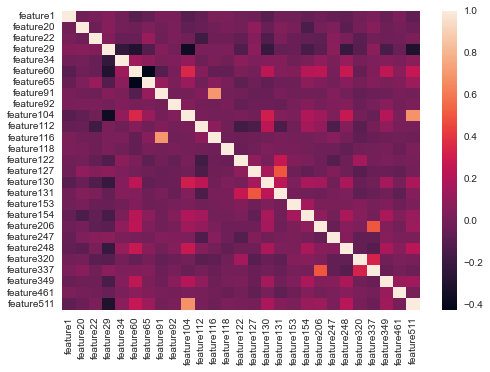

In [148]:
X_train_mds_dup=remove_duplicated_columns(X_train_mds)
X_train_mds_cor=remove_collinear_features(X_train_mds,0.7)
sns.heatmap(X_train_mds_cor.corr())

In [149]:
X_train_mds_cor

,feature1,feature20,feature22,feature29,feature34,feature60,feature65,feature91,feature92,feature104,...,feature153,feature154,feature206,feature247,feature248,feature320,feature337,feature349,feature461,feature511
0,3079.77,12.3686,-4750.75,66.4000,8.6915,0.6991,19.3009,9131.05990,-0.1835,-0.0095,...,0.2848,0.0127,9.22,3.99946,0.015200,11.0518,10.0329,0.02370,14.7554,84.9279
1,3001.36,12.4959,-5410.75,75.8111,8.3006,-1.4173,21.4173,8795.69000,0.0167,-0.0163,...,0.3080,0.0065,7.31,3.18582,0.031060,7.0269,13.2427,0.02720,12.1570,25.2308
2,3042.78,12.5553,-6456.75,71.3111,8.7418,10.2355,9.7645,8615.15000,-0.0316,-0.0108,...,0.2132,0.0148,8.80,3.06482,0.034500,10.8718,11.0695,0.01630,21.1169,46.2963
3,3018.64,12.4469,-5775.00,70.0556,8.6829,9.8518,30.1482,8363.73000,0.0105,-0.0038,...,0.6531,0.0159,7.77,4.30902,0.260816,9.4760,8.0615,0.03000,41.7748,114.2857
4,3020.29,12.4618,-6900.50,67.0222,8.5891,1.0336,18.9664,8510.42000,-0.0287,-0.0119,...,0.3602,0.0078,11.06,2.67580,0.017220,10.0446,10.0529,0.02430,23.1457,36.2869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1248,3057.31,12.4824,-6451.75,66.6000,9.1156,3.2964,16.7036,9116.96020,-0.0598,-0.0083,...,0.3740,0.0091,6.83,3.87290,0.018680,7.0315,11.9535,0.02640,18.4257,52.9323
1249,3009.71,12.5280,-5470.25,73.5667,8.4278,3.0345,16.9655,9064.39000,0.0856,-0.0115,...,0.4733,0.0055,9.58,1.75560,0.020300,8.0674,9.0320,0.01830,31.6124,34.8964
1250,3034.34,12.6278,-5972.75,68.8111,8.5155,11.4855,28.5145,8666.16000,0.0894,-0.0067,...,0.3214,0.0177,9.74,3.43744,0.138300,9.4364,9.9834,0.02680,60.3473,62.3377
1251,3025.21,12.5373,-5735.25,71.9111,9.0650,-2.3109,22.3109,8826.99996,0.2231,-0.0103,...,0.4326,0.0137,6.56,6.52930,0.020880,8.6338,9.9422,0.02386,16.9711,46.6586


# Sampling

In [136]:
def Sampling(X_train, y_train, sampler):
    
    #SMOTE
    if sampler == 'SMOTE':
        sampler = SMOTE(random_state=100)    
    
    #ROSE
    if sampler == 'ROSE':
        sampler = RandomOverSampler(random_state=100, shrinkage=1)

    #ADASYN
    if sampler == 'ADASYN':
        sampler = ADASYN(random_state=100)
    

    #SMOTTEENN
    if sampler == 'SMOTEENN' :
        sampler = SMOTEENN(random_state=100)
        
        
    #Random under Sampling
    if sampler == "randomunder":
        sampler = RandomUnderSampler(random_state=100)

    X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    counter = Counter(y_resampled)
    print(counter)
    return X_resampled, y_resampled

In [155]:
    #X_resampled, y_resampled = Sampling(X_train, y_train,'SMOTE')
#X_resampled_br, y_resampled_br= Sampling(X_train, y_train,'SMOTE')
X_resampled, y_resampled= Sampling(X_train_mds_cor, y_train,'SMOTE')

Counter({-1: 1170, 1: 1170})


# Preparation of Test Data 

In [160]:
# filter for missing value threshold 80
x_test_na=x_test.drop(axis=1, columns=x_train_na.index)

#constant volatility 
x_train_new_eda[x_train_new_eda['std']==0]
x_train_new_std= x_train_new_eda[x_train_new_eda["std"] == 0]
x_train_new_std

x_test_std=(x_test_na.drop(axis=1, columns=x_train_new_std.index))

# outlier treatment 
x_test_3s=x_test_std.copy()
zscore(x_test_3s,x_test_3s.columns,3)

# knn Imputation
imputed_test = pd.DataFrame(knn.transform(x_test_3s), columns = x_test_3s.columns)
imputed_test.isna().any().any()

#filter according to feature selection
#X_test=imputed_test.filter(final_features_br)
X_test=imputed_test.filter(final_features_mds)
X_test_cor= X_test.loc[:,X_train_mds_cor.columns]

In [152]:
X_test

,feature1,feature20,feature22,feature29,feature32,feature34,feature60,feature65,feature66,feature91,...,feature320,feature337,feature342,feature349,feature427,feature461,feature478,feature511,feature519,feature520
0,3031.22,12.5412,-5287.50,73.8333,3.2982,9.4336,-1.2400,21.2400,28.1969,8212.1200,...,7.7468,9.1827,3.4391,0.018700,1.4793,29.8359,6.5927,55.981900,1.387900,4.018800
1,3032.07,12.4922,-5613.50,67.8444,3.2901,8.7219,-4.1518,24.1518,30.4891,8689.8800,...,10.3008,9.5747,4.7775,0.026900,0.7327,31.0326,11.9817,73.007700,0.424469,0.115731
2,3045.48,12.5204,-5489.75,74.3778,3.5010,9.1637,-5.1491,25.1491,33.1448,8553.2301,...,4.6626,10.2432,2.7074,0.020800,0.9544,16.3653,6.2464,39.270700,1.644800,0.000000
3,2973.99,12.6082,-5100.00,73.0556,3.4772,8.8097,-5.6500,25.6500,31.1416,9019.6201,...,6.7496,8.3398,1.7046,0.028300,0.5319,12.9610,3.7154,58.895700,0.430533,4.331300
4,2919.71,12.3996,-5416.50,75.4000,3.4090,8.2720,5.3973,16.3450,20.2491,9345.4800,...,9.5830,13.4756,2.4584,0.028800,0.9850,25.5687,4.6771,39.391200,1.602600,0.117461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,2998.01,12.5510,-5012.75,67.6333,3.4470,8.7635,-1.4027,21.4027,28.4909,8295.2800,...,7.3783,8.6112,1.7381,0.018400,1.4588,43.4743,3.6998,30.905100,2.237900,0.117461
310,3100.19,12.4192,-5338.75,72.8556,3.3621,8.1728,4.6964,15.3036,21.7822,9435.8900,...,8.4352,11.8586,2.0250,0.249953,0.8921,33.6993,4.1743,44.083100,2.245600,0.087116
311,2950.46,12.4871,-4520.75,62.3667,3.5020,9.1784,20.0455,19.9545,26.3171,8791.8200,...,10.5399,9.6509,2.5763,0.021100,1.2708,25.6289,6.4725,176.854985,0.511504,42.711700
312,3012.45,12.5661,-5336.75,68.1111,3.3061,8.7402,-2.1409,22.1409,27.9241,8587.0802,...,9.1318,10.8288,2.0725,0.022900,0.4862,28.5461,4.4298,62.027800,1.908100,0.087291


# Build a Model 

In [157]:
def run_model(X_train, y_train, X_test, y_test):

    # building model before balancing data
    model = RandomForestClassifier(random_state=1, n_estimators=1000, max_depth=5)
    #elif which_model == 'LR':
     #   model = LogisticRegression(random_state=1)
    
    model.fit(X_train,y_train)


    #For TEST SPLIT
    y_pred= model.predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    accuracy= accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred) ##
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    specificity = cf_matrix[1][1] / ( cf_matrix[1][1] + cf_matrix[1][0] )
    auc = roc_auc_score(y_test, y_pred)
    type_1_error_FP = cf_matrix[0][1]
    type_2_error_FN = cf_matrix[1][0]
    log_loss_ = log_loss(y_test, y_pred)
    cohen_kappa_score_ = cohen_kappa_score(y_test, y_pred)
    #Note by default 1 is the positive label. Therefore, -1 is negative
    #bad waffe -> 2 line of matrix -> POSITIVE -> data = -1

    #For TRAIN SPLIT
    y_pred_train= model.predict(X_train)
    cf_matrix_train = confusion_matrix(y_train, y_pred_train)
    accuracy_train= accuracy_score(y_train, y_pred_train)
    f1_train = f1_score(y_train, y_pred_train) ##
    precision_train = precision_score(y_train, y_pred_train)
    recall_train = recall_score(y_train, y_pred_train)
    specificity_train = cf_matrix_train[1][1] / ( cf_matrix_train[1][1] + cf_matrix_train[1][0] )
    auc_train = roc_auc_score(y_train, y_pred_train)
    type_1_error_FP_train = cf_matrix_train[0][1]
    type_2_error_FN_train = cf_matrix_train[1][0]




    return cf_matrix, accuracy, f1, precision, recall, specificity, type_1_error_FP, type_2_error_FN, auc,log_loss_,cohen_kappa_score_, cf_matrix_train, accuracy_train, f1_train, precision_train, recall_train, specificity_train, type_1_error_FP_train, type_2_error_FN_train, auc_train

#run_model(X_train, y_train, X_test, y_test)

In [161]:
run_model(X_resampled,y_resampled,X_test_cor,y_test)

(array([[262,  31],
        [ 13,   8]], dtype=int64),
 0.8598726114649682,
 0.26666666666666666,
 0.20512820512820512,
 0.38095238095238093,
 0.38095238095238093,
 31,
 13,
 0.6375751665854055,
 4.839907480561804,
 0.1968375770259272,
 array([[1040,  130],
        [  32, 1138]], dtype=int64),
 0.9307692307692308,
 0.9335520918785891,
 0.8974763406940063,
 0.9726495726495726,
 0.9726495726495726,
 130,
 32,
 0.9307692307692307)

# Graphas for presentation

### the boruta pi binom graph concept

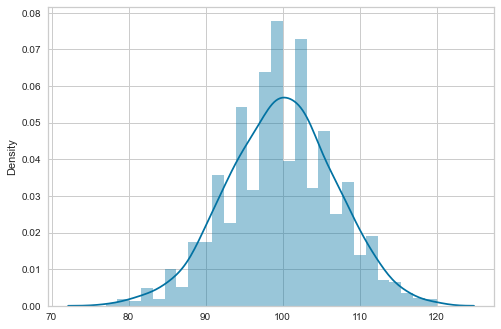

In [66]:
from scipy.stats import binom
n = 10000
p = 0.5
s = list(range(n + 1))
#a = [binom.pmf(r, n, p) for r in s]
a = np.random.binomial(n = 200, p = 0.5, size = 1500)
sns.distplot(a, hist=True, kde=True)
plt.show()

In [97]:
FS_train_target = pd.concat([X_train,y_train],axis=1)

In [ ]:
FS_train_target

In [95]:
y_train.index=X_train.index


In [96]:
y_train.index

RangeIndex(start=0, stop=1253, step=1)

In [ ]:
sns.pairplot(data=   ,palette='rocket')

##### Visualisation Boruta Ranking

In [177]:
# array to dataframe 
boruta_ranking = pd.DataFrame(data=feature_ranking, index=retransformed_train.columns.values, columns=['values'])

NameError: name 'feature_ranking' is not defined

In [183]:
boruta_ranking['Variable'] = boruta_ranking.index
boruta_ranking.sort_values(['values'], ascending=True, inplace=True)
boruta_ranking_30=boruta_ranking.loc[boruta_ranking['values']<=30]

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44]),
 [Text(1, 0, 'feature122'),
  Text(2, 0, 'feature60'),
  Text(3, 0, 'feature34'),
  Text(4, 0, 'feature478'),
  Text(5, 0, 'feature427'),
  Text(6, 0, 'feature22'),
  Text(7, 0, 'feature20'),
  Text(8, 0, 'feature130'),
  Text(9, 0, 'feature131'),
  Text(10, 0, 'feature349'),
  Text(11, 0, 'feature520'),
  Text(12, 0, 'feature206'),
  Text(13, 0, 'feature248'),
  Text(14, 0, 'feature342'),
  Text(15, 0, 'feature104'),
  Text(16, 0, 'feature511'),
  Text(17, 0, 'feature1'),
  Text(18, 0, 'feature127'),
  Text(19, 0, 'feature65'),
  Text(20, 0, 'feature153'),
  Text(21, 0, 'feature118'),
  Text(22, 0, 'feature112'),
  Text(23, 0, 'feature154'),
  Text(24, 0, 'feature91'),
  Text(25, 0, 'feature66'),
  Text(26, 0, 'feature288'),
  Text(27, 0, 'feature426'),
  Text(28, 0, 'feature125'),
  Te

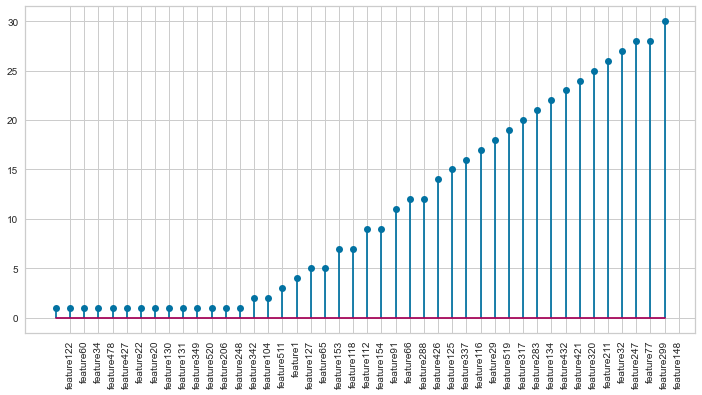

In [204]:
fig,popx = plt.subplots(figsize=(12,6))
popx= plt.stem(boruta_ranking_30['values'])
my_range=range(1,len(boruta_ranking_30.index)+1)
plt.xticks(my_range,boruta_ranking_30['Variable'])
plt.xticks(rotation=90)

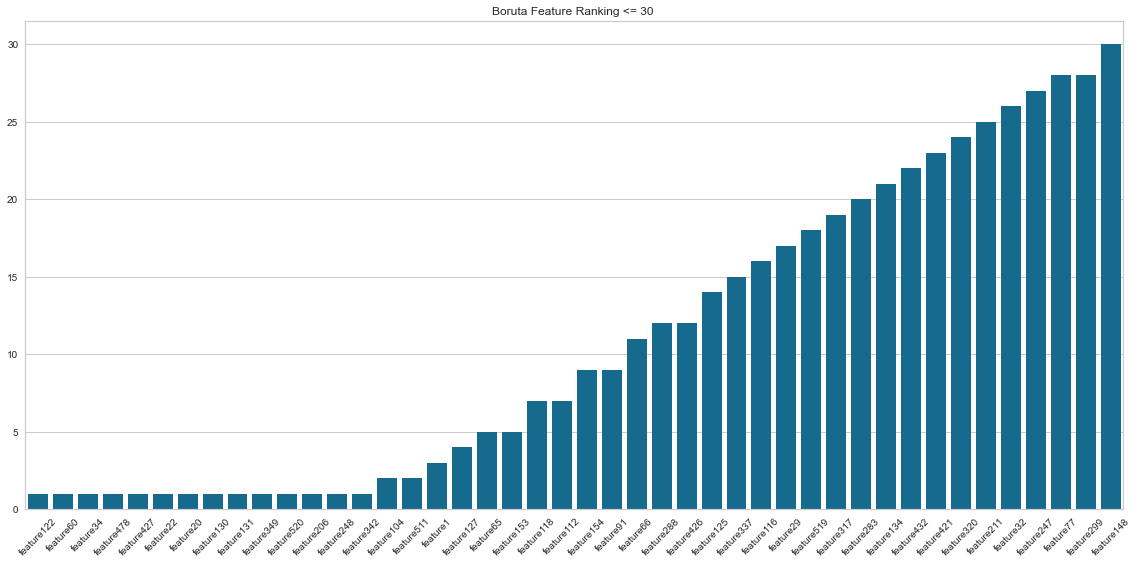

In [74]:
fig,ax = plt.subplots(figsize=(16,8))
#ax = sns.barplot(x='values',y='Variable',data=boruta_ranking_30, color='b')
ax = sns.barplot(y='values',x='Variable',data=boruta_ranking_30, color='b')
plt.title('Boruta Feature Ranking <= 30 ')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=45)
plt.tight_layout()

# Appendix for Feature Selection

### BOOSTAROOTA

In [ ]:
def BOOSTAROOTA_FS(X,y):
  
  #OHE the variables - BoostARoota may break if not done
  #X = pd.getdummies(X)
  #Specify the evaluation metric: can use whichever you like as long as recognized by XGBoost
    #EXCEPTION: multi-class currently only supports "mlogloss" so much be passed in as eval_metric
  
  br = BoostARoota(metric='logloss',max_rounds=300 )#iter =50 result in more clumns
  #Fit the model for the subset of variables
  br.fit(X, y)
  keep = br.keep_vars_
  #len(X.columns)
  #len(br.keep_vars_)
  #Can look at the important variables - will return a pandas series
 
  #Then modify dataframe to only include the important variables
  br_df = br.transform(x)
  #br_df2 = br.fit_transform(X,y)
  #keep = br_df2.keep_vars_
  #Dimension Reduction
  #print("Original training set has " + str(X.shape) + " dimensions. \n" +\
  #"BoostARoota with .fit() and .transform() reduces to " + str(br_df.shape) + " dimensions. \n" +\
  #"BoostARoota with .fit_transform() reduces to " + str(br_df2.shape) + " dimensions.\n" +\
  #"The two methods may give a slightly different dimensions because of random variation as it is being refit")
  ########################################################################################################################
  #
  #  Test that its working with any classifier
  #
  ########################################################################################################################
  #from sklearn.ensemble import RandomForestClassifier
  #clf_br = RandomForestClassifier()
  ##from sklearn.ensemble import ExtraTreesClassifier
  ##clf = ExtraTreesClassifier()
  #br = BoostARoota(clf=clf_br)
  #new_train = br.fit_transform(X, y)
  return br_df, keep

#### Boruta Shap tenative feature included test

In [ ]:
modelshap_test = RandomForestClassifier(n_jobs=-1,n_estimators=100, max_depth=5, random_state=100)

    # define model for resp. classifier
modelshap_test.fit(retransformed_train,y_train)
feature_names_test = np.array(retransformed_train.columns)
# define Boruta Sahp feature selection method
feature_selector_test = BorutaShap(model=modelshap_test,
                          importance_measure='shap',
                          classification=True)  # find all relevant features
feature_selector_test.fit(retransformed_train,y_train,n_trials=100,sample = False, verbose = True,random_state=100)  
feature_selector_test.plot(which_features='accepted',figsize=(20,10))

tentative=retransformed_train.loc[:,feature_selector_test.tentative]
selected=feature_selector_test.Subset()
selten=pd.concat([selected,tentative],axis=1)

tentative=retransformed_train.loc[:,feature_selector_test.tentative]
tentative
selected=feature_selector_test.Subset()
selected
selten=pd.concat([selected,tentative],axis=1)
selten

feature_selector_test.Subset(tentative=False)

#### Boruta SHap with importance 'Gini'

100%|██████████| 100/100 [01:09<00:00,  1.43it/s]

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


10 attributes confirmed important: ['feature248', 'feature520', 'feature461', 'feature299', 'feature469', 'feature130', 'feature478', 'feature164', 'feature34', 'feature60']
455 attributes confirmed unimportant: ['feature570', 'feature338', 'feature432', 'feature273', 'feature367', 'feature71', 'feature254', 'feature589', 'feature547', 'feature133', 'feature406', 'feature322', 'feature160', 'feature573', 'feature436', 'feature578', 'feature62', 'feature548', 'feature1', 'feature428', 'feature569', 'feature251', 'feature410', 'feature388', 'feature25', 'feature347', 'feature91', 'feature186', 'feature89', 'feature411', 'feature350', 'feature199', 'feature358', 'feature528', 'feature249', 'feature288', 'feature577', 'feature456', 'feature283', 'feature441', 'feature387', 'feature101', 'feature511', 'feature275', 'feature218', 'feature183', 'feature239', 'feature21', 'feature152', 'feature8', 'feature361', 'feature558', 'feature566', 'feature453', 'feature18', 'feature304', 'feature75', '

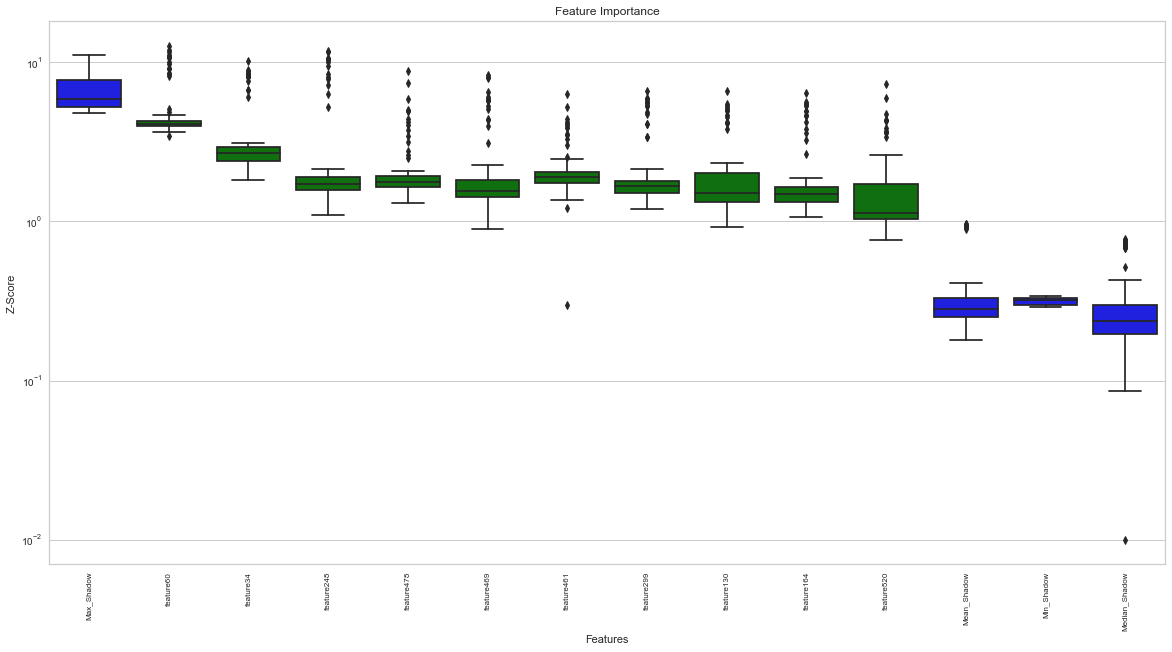

In [33]:
X_trainshap= BorutaShapFeatureSelection_gain(retransformed_train,y_train)

###  function for boruta with different models

In [32]:
#Boruta function with random forest

def Classifier (X, y,m,bor_iter) :
    feature_names = np.array(X.columns)

    # define random forest classifier
    if m=='XGB':
        print('\n',"Boruta with ",m," as classifier",'\n')
        model = xgb.XGBClassifier()
        #model=xgb.XGBClassifier(objective= 'binary:logistic')
        #model.fit(X,y)
    elif m=='Rf':
        print('\n',"Boruta with ",m," as classifier",'\n')
        model = RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample', max_depth=5, random_state=100)
    model.fit(X, y)
    # define Boruta feature selection method
    
    feature_selector = BorutaPy(model, n_estimators='auto', verbose=2, random_state=100, max_iter=bor_iter)

    # find all relevant features
    feature_selector.fit(X.to_numpy(),y)

    # check selected features
    feature_selector.support_

    # check ranking of features
    feature_ranking=feature_selector.ranking_

    # zip feature names, ranks, and decisions 
    feature_ranks = list(zip(feature_names, 
                             feature_selector.ranking_, 
                             feature_selector.support_))

    # print the results
    for feat in feature_ranks:
        print('Feature: {:<30} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))
        
    final_features = list()
    indexes = np.where(feature_selector.ranking_ <= 1)
    for x in np.nditer(indexes):
        final_features.append(feature_names[x])
    print(final_features)
    
 # call transform() on X to filter it down to selected features
    return pd.DataFrame(X.filter(final_features)) , final_features, feature_ranking
 
 def boruta(X,y):
    bor_clf = ['Rf', 'XGB']
    bor_noit=140
    for m in bor_clf:
        if m=='Rf':
            X_train_rf , final_features_rf, feature_ranking_rf = BorutaFSModel(retransformed_train,y_train,m,bor_noit)
            X_train=X_train_rf
        elif m== 'XGB':
            X_train_xgb , final_features_xgb, feature_ranking_xgb = BorutaFSModel(retransformed_train,y_train,m,bor_noit)
            X_train=X_train_xgb
    return X_train;
    
  FS_techniques=['Boruta','RFE','BorutaShap','Permutation','Lasso']
for fs in fs_techniques:
    def feature_selection(X,y,fs)
        m = [rfe, svm]
        def boruta (X,y,m)


def feature_selection(X,y,fs):
    FS_techniques=['Boruta','RFE','BorutaShap','Permutation','Lasso']
    for fs in FS_techniques:
        if fs=='Boruta':
            classifier=['RF','XGB']
            for c in classifier:
                if c =='Rf':
                    X_train_rf , final_features_rf, feature_ranking_rf = BorutaFSModel(retransformed_train,y_train,m,bor_noit)
                    X_train=X_train_rf
                elif c == 'XGB':
                    X_train_xgb , final_features_xgb, feature_ranking_xgb = BorutaFSModel(retransformed_train,y_train,m,bor_noit)
                    X_train=X_train_xgb
        if fs=='RFE':
            classifier=['RF','SVM']
            for c in classifier:
                if c =='Rf':
                    X_train_rfe, final_features_rfe = RFEFeatureSelection(imputed_train,y_train)
                    X_train=X_train_rfe
                    # resample them
                    # confusion matrix ,accuracy 
                elif c == 'SVM':
                    X_train_rfesvm, final_features_rfesvm = RFESVMFeatureSelection(imputed_train,y_train)
                    X_train=X_train_xgb
        if fs == 'BorutaShap':
            classifier=['RF','KNN','XGB']
            for c in classifier:
                if c =='Rf':
                    X_trainshap= BorutaShapFeatureSelection(retransformed_train,y_train,)
                    X_train=X_trainshap
                elif c == 'KNN':,
                    X_trainknnscaled= BorutaknnFeatureSelection(imputed_train,y_train)
                    X_train=X_trainknnscaled
                elif c == 'XGB':
                    X_trainxgb= BorutaxgbFeatureSelection(retransformed_train,y_train)
                    X_train=X_trainxgb
        elif fs == 'PermutationImportance':
            function
return X_train
#sampling
#model 

        
    

### Boruta Shap  KNN neighbors 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
#Boruta Shap function with KNN
#KNN is distance base algroritm. Scaled data is used

def BorutaknnFeatureSelection (X, y) :
    feature_names = np.array(X.columns)

    # define random forest classifier
    modelknn = KNeighborsClassifier()
    modelknn.fit(X,y)
    
    # define Boruta feature selection method
    feature_selector = BorutaShap(model=modelknn,
                              importance_measure='shap',
                              classification=True)

    # find all relevant features
    feature_selector.fit(X,y,n_trials=100,sample = False, verbose = True,random_state=100)
    feature_selector.plot(which_features='accepted',figsize=(20,10))
 # call transform() on X to filter it down to selected features
    return  feature_selector.Subset()

100%|██████████| 100/100 [00:46<00:00,  2.16it/s]


10 attributes confirmed important: ['feature248', 'feature164', 'feature34', 'feature478', 'feature435', 'feature104', 'feature469', 'feature60', 'feature299', 'feature520']
456 attributes confirmed unimportant: ['feature122', 'feature468', 'feature183', 'feature556', 'feature130', 'feature129', 'feature273', 'feature564', 'feature571', 'feature488', 'feature117', 'feature197', 'feature584', 'feature471', 'feature124', 'feature511', 'feature171', 'feature544', 'feature115', 'feature89', 'feature214', 'feature134', 'feature245', 'feature309', 'feature586', 'feature475', 'feature201', 'feature473', 'feature116', 'feature85', 'feature133', 'feature367', 'feature33', 'feature10', 'feature46', 'feature149', 'feature96', 'feature363', 'feature54', 'feature196', 'feature449', 'feature101', 'feature500', 'feature207', 'feature494', 'feature281', 'feature141', 'feature44', 'feature74', 'feature341', 'feature9', 'feature470', 'feature283', 'feature453', 'feature11', 'feature21', 'feature446', 'f

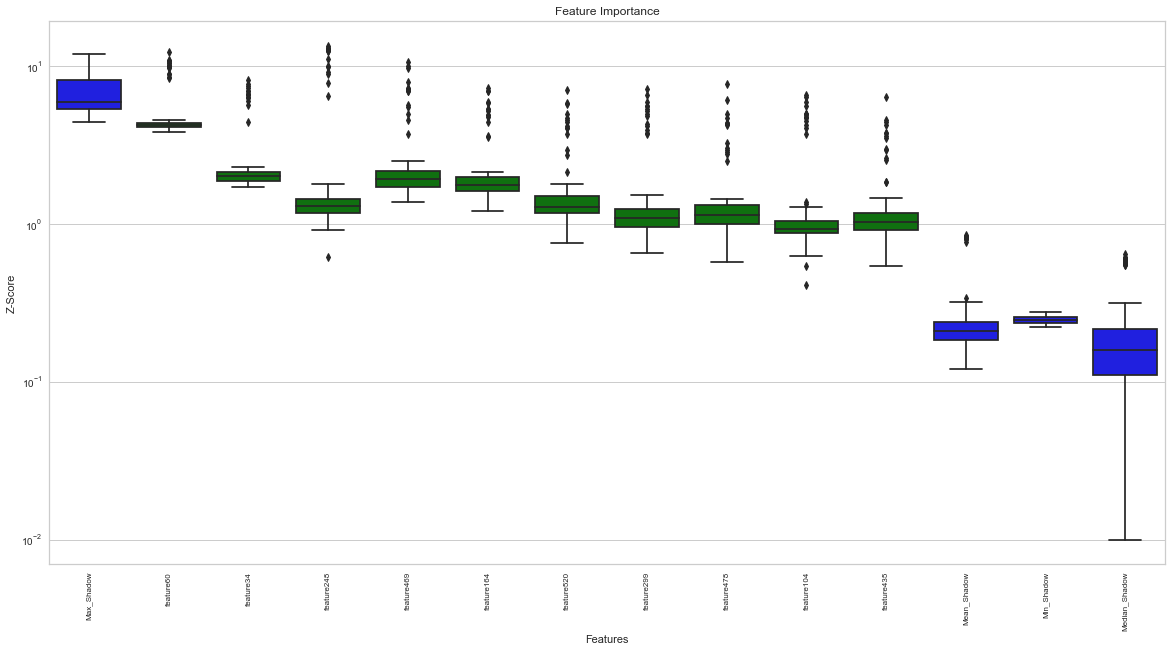

In [ ]:
X_trainknnscaled= BorutaknnFeatureSelection(imputed_train,y_train)

####Visualise Boruta All

Text(0, 0.5, '')

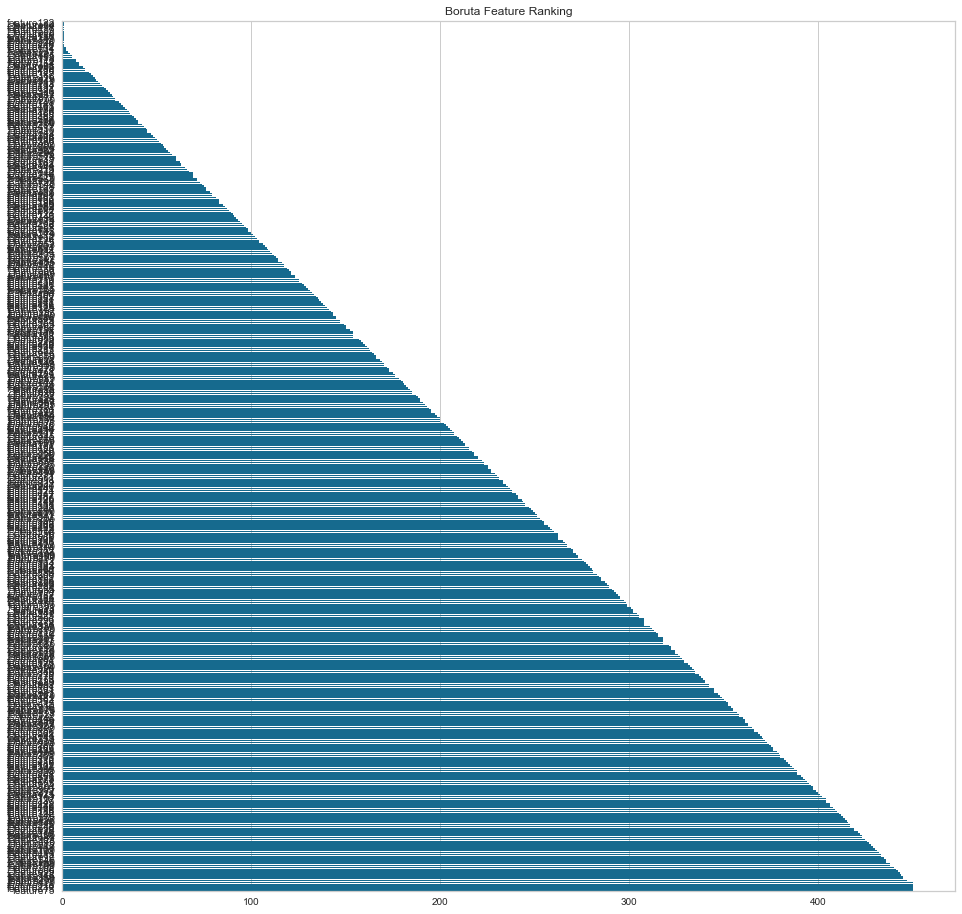

In [ ]:
fig,ax = plt.subplots(figsize=(16,16))
ax = sns.barplot(x='values',y='Variable',data=boruta_ranking, color='b')
plt.title('Boruta Feature Ranking')
plt.xlabel('')
plt.ylabel('')
#plt.tight_layout()

# Checking - manual Boruta without the function

In [ ]:
# 
# # prepare the data for boruta by fitting it to random forest Classifier 
#from sklearn.ensemble import RandomForestClassifier

# define random forest classifier
#forest = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
#forest.fit(imputed_train, y_train)
#iteration=200
# define Boruta feature selection method
#feat_selector = BorutaPy(forest, n_estimators='auto', verbose=2, random_state=1,max_iter=iteration)

# find all relevant features
#feat_selector.fit(np.array(imputed_train),np.array(y_train))
#print("Ranking: ",feat_selector.ranking_)          
#print("No. of significant features: ", feat_selector.n_features_) 
#feat_selector.support_
#green_area = imputed_train.columns[feat_selector.support_].to_list()
#blue_area = imputed_train.columns[feat_selector.ranking_].to_list()
#X_best_features= feat_selector.transform(imputed_train.to_numpy())

# Model

In [ ]:
# Create the random grid
rf_params = {'n_estimators': [25, 50],
               'criterion' : ['entropy', 'gini'],
               'max_features': ['sqrt', 'auto'],
               'max_depth': [3, 10],
               'min_samples_split': [75,100],
               'min_samples_leaf': [1, 10],
               'max_samples' : [110, 200]
              }

In [ ]:
# Create a base model to tune
rf = RandomForestClassifier(random_state=100)

# Grid Search
rf_random = GridSearchCV(estimator = rf, param_grid = rf_params, scoring='roc_auc', cv = 5, verbose=1)

# Fit the random search model
rf_random.fit(X_resampled, y_resampled)
feature_selector7 = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=100)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


In [ ]:
# Printing the best Parameters and best estimator

#Printing the best estimator

print('\n Best estimator:')
print(rf_random.best_estimator_)

print('\n Best hyperparameters:')
print(rf_random.best_params_)


 Best estimator:
RandomForestClassifier(criterion='entropy', max_depth=10, max_features='sqrt',
                       max_samples=200, min_samples_split=75, n_estimators=50,
                       random_state=100)

 Best hyperparameters:
{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'max_samples': 200, 'min_samples_leaf': 1, 'min_samples_split': 75, 'n_estimators': 50}


In [ ]:
# Evaluation using Startified K Fold cross validation
cv = StratifiedKFold(n_splits=5)
scores = cross_val_score(rf_random.best_estimator_, X_resampled, y_resampled, cv=cv, scoring = 'roc_auc')
print(scores.mean())
# fit
rf_random.best_estimator_.fit(X_resampled, y_resampled)    
# predict
y_pred_test = rf_random.best_estimator_.predict(X_test)
# View accuracy score
accuracyFinal = accuracy_score(y_test, y_pred_test)
print('Test Accuracy : ', accuracyFinal)

0.8801592519541238
Test Accuracy :  0.8089171974522293


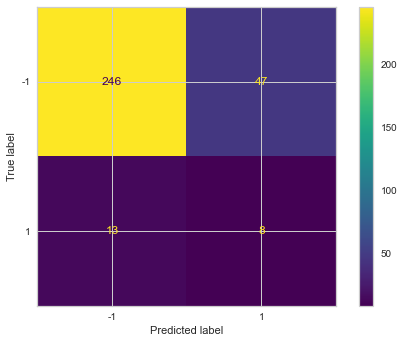

              precision    recall  f1-score   support

          -1       0.95      0.84      0.89       293
           1       0.15      0.38      0.21        21

    accuracy                           0.81       314
   macro avg       0.55      0.61      0.55       314
weighted avg       0.90      0.81      0.85       314



In [ ]:
# Plot confussion matrix
cm = confusion_matrix(y_test, y_pred_test, labels=rf_random.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rf_random.best_estimator_.classes_)
disp.plot()
plt.show()
# View the classification report for test data and predictions
print(classification_report(y_test, y_pred_test)) 

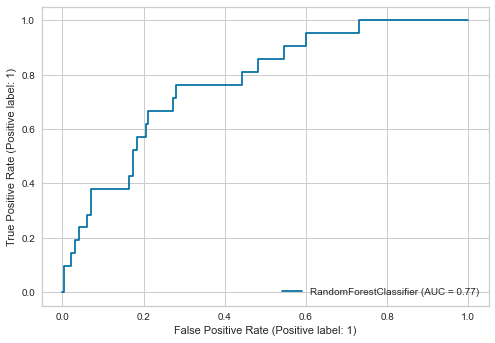

In [ ]:
# ROC curve
metrics.RocCurveDisplay.from_estimator(rf_random.best_estimator_, X_test, y_test)
plt.show()

# Build Model

## Random forest

### function for running model and printing accuracy score 

In [ ]:
def run_model(X, y,X_test,y_test):
    # building model before balancing data
    clf = RandomForestClassifier(random_state=1, n_estimators=1000, max_depth=5)
    clf.fit(X,y)
    y_predicted_test= clf.predict(X_test)
    score1= accuracy_score(y_test, y_predicted_test)
    return score1

In [ ]:
#### run model on training data before sampling 
#run_model(imputed_train,y_train,imputed_test,y_test)
# train the model on feature selected X_train and y_train (without sampling ) and test it on prepared test data 
run_model(X_train,y_train,X_test,y_test)

0.9331210191082803

In [ ]:
#### run model on training data after sampling 
run_model(X_resampled,y_resampled,X_test,y_test)

0.8407643312101911

In [ ]:
run_model(X_resampled5, y_resampled5,X_test5,y_test)

0.7898089171974523